In [1]:
import glob
import re
import pandas as pd
from yattag import Doc
import unicodedata
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import textdistance
import seaborn as sns

Recuperando dados do sis_editatais

In [2]:
sis_editais = pd.read_excel('data/2020_08_11_Sis_editais.xlsx')
# Filtro temporario
sis_editais_2014 = sis_editais[sis_editais['anoEdital'] == 2014]

In [3]:
txt_files = glob.glob('data/text/**/**/*.txt')

In [4]:
all_contracts = []
regex_abertura = '((?:aviso de abetura|aviso de licitacao|pregao eletronico|aviso de pregao eletronico|pregao presencial)[\s\S]*?\.\n)'
for txt in txt_files:
    instances = re.findall(regex_abertura,
                            unicodedata.normalize('NFKD', open(txt, encoding='utf-8').read()), 
                            re.IGNORECASE)
    all_contracts.extend(instances)

---
### Comparação da quantidade de blocos encontrados

In [5]:
print("REGEX")
print(len(all_contracts))
print("Sis Editais")
print(len(sis_editais))

REGEX
23913
Sis Editais
13872


---
### Comparação do tamanho entre os blocos de licitação encontrados

780


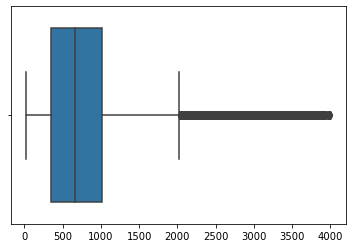

In [9]:
all_contracts_lens = np.array(list(map(len, all_contracts)))
outliers_count = len(all_contracts_lens[all_contracts_lens > 4000])
all_contracts_lens = all_contracts_lens[all_contracts_lens < 4000]
print(outliers_count)
sns.boxplot(x=all_contracts_lens)
plt.show()

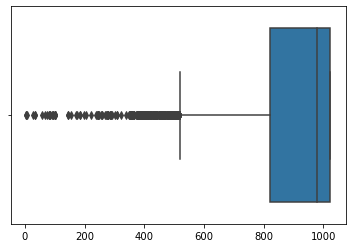

In [10]:
descObjeto = list(map(str, sis_editais['descObjeto'].values))
descObjeto_lens = np.array(list(map(len, descObjeto)))
#descObjeto_lens = descObjeto_lens[descObjeto_lens < 4000]
sns.boxplot(x=descObjeto_lens)
plt.show()

In [11]:
regex_dict = {'processo': 'processo[\s\S]*(\d{3}.\d{6}/\d{4}?)|(\d{5}[\.|\-]\d{8}\/\d{4}-\d{2})|(\d{5}[\.|\-]\d{8}\/\d{4}-\d{2})', 
              'objeto': 'objeto[\s\S]*?:?([\s\S]*?)\.',
              'valor_estimado': 'valor[\s\S]*(?:estimado)?[\s\S]*?(\d+(?:\.\d+)*,\d\d)', 
              'prazo': 'prazo[s]?:?([\s\S]*)data', 
              'tipo': 'Tipo[:]?([\s\S]*?)\.',
              'data': 'data[\s\S]*?\.*(\d{2}/\d{2}/\d{4}[\s\S].*\d)|(\d+ de .*),',
}

df_dict = {
    'processo': [],
    'objeto': [],
    'valor_estimado': [],
    'prazo': [],
    'tipo': [],
    'data': [],
    'texto': [],
}

In [12]:
for contract in all_contracts:
    df_dict['texto'].append(contract)
    for field in regex_dict:
        match = re.search(regex_dict[field], contract, re.IGNORECASE)
        if match:
            res = tuple(x for x in match.groups() if x is not None)
            df_dict[field].append(res[0])
        else:
            df_dict[field].append(np.nan)

df = pd.DataFrame.from_dict(df_dict)
df.to_csv('abertura_regex.csv')

In [21]:
textdistance.ratcliff_obershelp.normalized_distance(str(df['texto'][0]), unicodedata.normalize('NFKD', sis_editais['descObjeto'][3349]))

0.7478731631863882

Primeira comparação em relação ao texto inteiro do ato extraido.
Na base de dados do Sis Editais, o mesmo texto se encontra na coluna "descObjeto" 

In [16]:
texto_regex = []
texto_sis_editais = []
score_index = []
df = df[:100]
for index, row in df.iterrows():
    print(row['texto'])
    similar = []
    for index2, row2 in sis_editais.iterrows():
        texto_sis = unicodedata.normalize('NFKD', str(row2['descObjeto']))
        sim = textdistance.jaccard.normalized_distance(row['texto'], texto_sis)
        if sim < 0.18:
           # print(row['texto'], row2['descObjeto'])
           # print('------------------------------')
            similar.append([index2, sim])
            print(similar)
    if similar:
        minimo = min(similar, key=lambda x: x[1])
        score_index.append(minimo[1])
        texto_regex.append(row['texto'])
        texto_sis_editais.append(sis_editais['descObjeto'][minimo[0]])
        print(minimo)
    
df_sis = pd.DataFrame({'texto_regex': texto_regex, 'text_sis_editais': texto_sis_editais, 'score': score_index})
df_sis.to_csv('sis_editais_comparacao.csv')

Pregao Eletronico no 12/2013-SEDF. Partes: 
SEDF X SAO LUCAS INDUSTRIA E COMERCIO DE LATICINIOS LTDA - EPP; Objeto: a 
aquisicao de genero alimenticio nas especificacoes   do Edital de Licitacao  Pregao Eletronico 
no 12/2013  SEDF. Unidade Orcamentaria: 18101; Programas de Trabalho: 12.361.6221.296
4.0001/12.362.6221.2964.0004/12.365.6221.2964.9316/12.365.6221.2964.9317/12.366.6221.

Pregao Eletronico no 10/2013. Signatarios: Pela Secretaria de 
Estado de Governo: Gustavo Ponce de Leon Soriano Lago e pela Contratada: Ruben Eleomar 
Parrilla Albarracin. Processo 360.000.517/2013. EXTRATO DA ATA DE REGISTRO DE PRECOS No 12/2013
VALIDADE ATE 13/11/2014
Contratada: PREMIER EVENTOS LTDA - EPP; Objeto da ARP: contratacao de servicos de 
organizacao de eventos e correlatos, a serem realizados pela Secretaria de Estado de Governo, sob 
demanda, compreendendo a organizacao, execucao e acompanhamento e fornecimento de bens, 
infraestrutura e apoio logistico, em regime de empreitada, conforme es